<a href="https://colab.research.google.com/github/jjzsilva9/vico/blob/main/VICO_Week_2_Practical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **VICO Week 2 Practical: introduction to colour correction, radiometry and photometry**

Like last Friday, today we will be using numpy, matplotlib and OpenCV. The following block should look familiar, since it is essentially the same as last week. It imports what needed and downloads some images to the session storage.

In [1]:
# Download the image
!wget https://www.dropbox.com/s/68arqqi52zb9f97/IMG_FG_BL.tiff

# Download the dark frame
!wget https://www.dropbox.com/s/ltgfaddkuaoh23l/IMG_DF_BL.tiff


import numpy as np
import cv2
import matplotlib.pyplot as plt


--2024-10-04 12:48:30--  https://www.dropbox.com/s/68arqqi52zb9f97/IMG_FG_BL.tiff
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/kwmht7eqe6cjptakl7did/IMG_FG_BL.tiff?rlkey=sen4a0tya0cax1jx171n8f169 [following]
--2024-10-04 12:48:30--  https://www.dropbox.com/scl/fi/kwmht7eqe6cjptakl7did/IMG_FG_BL.tiff?rlkey=sen4a0tya0cax1jx171n8f169
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8236ba28d288c30256812621cd.dl.dropboxusercontent.com/cd/0/inline/Cbzw6npBCdBEamhovrJA6sciv0vNWQsf_iilFavnrIhKsfluJZ52dqxigFCZSWsVbV2NDJSeTS7KNfoUdl5bRABZigecOo_fwywuwFfV8ssizq5d7XLsxXaylNY-Hd1mk0IqrZkPdMykv655eYWqHlUF/file# [following]
--2024-10-04 12:48:31--  https://uc8236ba28d288c30256812621cd.dl.dropboxusercontent.com/cd/0/in

Let's load the two images. One is the photograph of a portion of a colour checker chart, the other one is a dark frame.


Image datatype: uint16
Image dimensions: (3012, 2012)


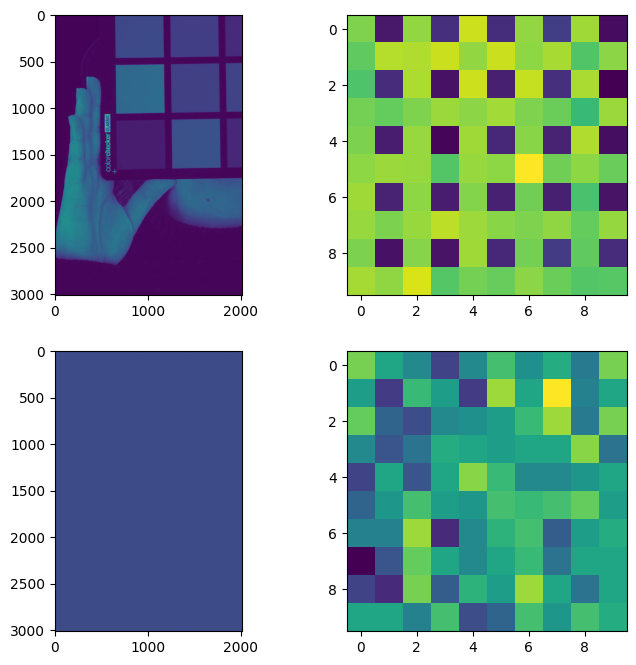

In [2]:
img = cv2.imread("IMG_FG_BL.tiff", cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
dark_frame = cv2.imread("IMG_DF_BL.tiff", cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

# Both images in bayer format, so uint16 single channel
print('Image datatype:',img.dtype)
print('Image dimensions:',img.shape)

fig=plt.figure(figsize=(8, 8))
fig.add_subplot(2,2,1)
plt.imshow(img)
fig.add_subplot(2,2,2)
plt.imshow(img[800:810,900:910])
fig.add_subplot(2,2,3)
plt.imshow(dark_frame)
fig.add_subplot(2,2,4)
plt.imshow(dark_frame)
plt.imshow(dark_frame[800:810,900:910])
plt.show()

If we look at a small homogeneous area of the image (somewhere within a patch of the colour checker chart), we can see the bayer pattern. If we do the same with the dark frame (photograph taken with the lens cap on) we just see random pixels value. That's not surprising, given that the dark frame provide us with a way to estimate sensor noise, as well as the sensor black level.

In [3]:
black_level = round(np.mean(dark_frame))
print('The estimated black level is: ', black_level )

The estimated black level is:  2048


Let's subtract the black level from the image and apply a debayering algorithm from the openCV library and display the result. We need to know the bayer pattern to do so! In this case we will use the constant *cv2.COLOR_BAYER_GR2RGB*. Have a look at this link to the the other possible bayer patterns: https://docs.opencv.org/3.4/de/d25/imgproc_color_conversions.html

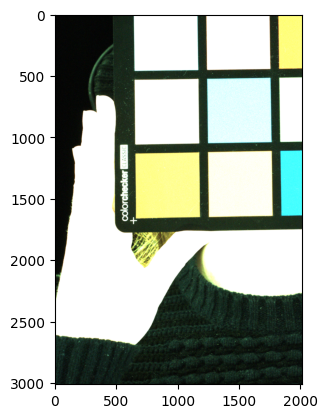

In [4]:

img = cv2.subtract(img, dark_frame)

colour_img = cv2.cvtColor(img, cv2.COLOR_BAYER_GR2RGB)
plt.imshow(colour_img)

We had no issue in visualising the grayscale bayer pattern images. However, since `colour_img` has 3 channels and it is uint16, all the values are clipped to 255, leading to the saturated image above.
To visualise it, we can rescale it to the [0-1] range, accounding for the actual range of values acquired by the camera (that is, between the black level and the max value - in this case `2**16-1`) and then gamma correct the image. Let's use gamma 2.2.

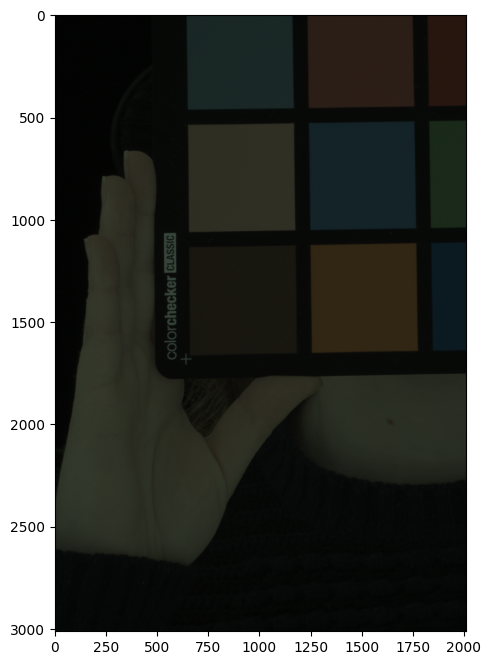

In [5]:

colour_img_display = colour_img.astype(np.float32)/((2**16-1)-black_level)

fig=plt.figure(figsize=(8, 8))
plt.imshow(np.power(colour_img_display,1/2.2))


Let's perform the debayering using a different algorithm, edge-aware this time.

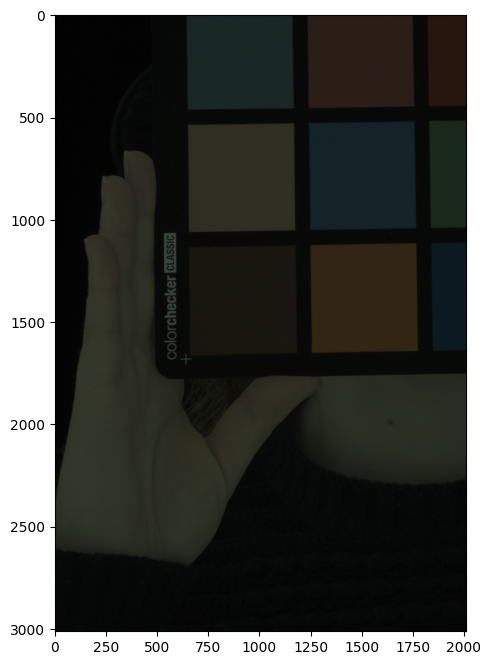

In [6]:
colour_img_EA = cv2.cvtColor(img, cv2.COLOR_BAYER_GR2RGB_EA)
colour_img_EA_display = colour_img_EA.astype(np.float32)/((2**16-1)-black_level)

fig=plt.figure(figsize=(8, 8))
plt.imshow(np.power(colour_img_EA_display,1/2.2))



The difference is not immediately noticeable, at least at this scale. Let's compute a difference map between the output of the two different debayering algorithms. In particular, we will work on a greyscale version of the images,computed according to the formula reported at this link: https://docs.opencv.org/3.4/de/d25/imgproc_color_conversions.html. Refrain from using the term "luminance": the images are still in camera colour space and the equation is rather approximated.

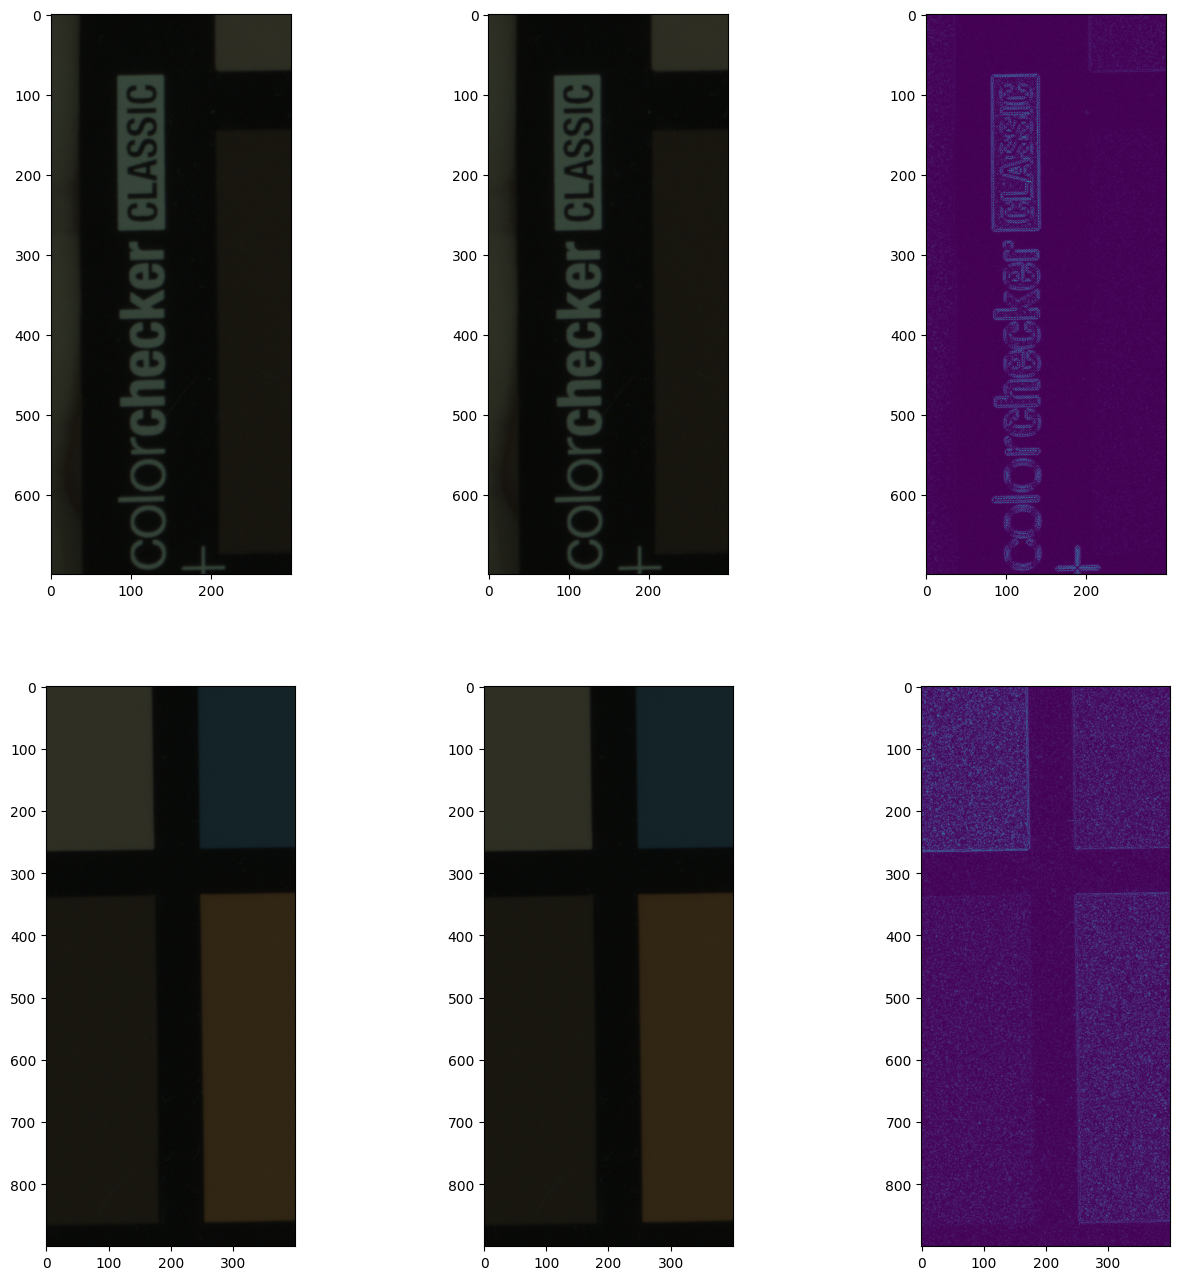

In [7]:
grey_img_EA = cv2.cvtColor(colour_img_EA, cv2.COLOR_RGB2GRAY)
grey_img_EA = grey_img_EA.astype(np.float32)/((2**16-1)-black_level)

grey_img = cv2.cvtColor(colour_img, cv2.COLOR_RGB2GRAY)
grey_img = grey_img.astype(np.float32)/((2**16-1)-black_level)

diff = abs(grey_img - grey_img_EA);



detail_01_colour = colour_img_display[990:1690,450:750]
detail_01_colour_EA = colour_img_EA_display[990:1690,450:750]

detail_02_colour = colour_img_display[790:1690,1000:1400]
detail_02_colour_EA = colour_img_EA_display[790:1690,1000:1400]



fig=plt.figure(figsize=(16, 16))
fig.add_subplot(2,3,1)
plt.imshow(np.power(detail_01_colour,1/2.2))
fig.add_subplot(2,3,2)
plt.imshow(np.power(detail_01_colour_EA,1/2.2));
fig.add_subplot(2,3,3)
plt.imshow(diff[990:1690,450:750]);
fig.add_subplot(2,3,4)
plt.imshow(np.power(detail_02_colour,1/2.2));
fig.add_subplot(2,3,5)
plt.imshow(np.power(detail_02_colour_EA,1/2.2));
fig.add_subplot(2,3,6)
plt.imshow(diff[790:1690,1000:1400])
plt.show()

Unsurprisingly, the main differences are visible around strong edges in the image (as well as in noisy areas). The image `colour_img_display` (as well as `colour_img_EA_display`) are in linear camera RGB and are ready for colour correction.

# Task 1: Debayering

---
Load the two images below, taken with a different camera compared to the one used in the previous example (this camera might use a different Bayer pattern). Correct for the dark frame, debayer the resulting image, and then visualize the result.

Hint: If the colors appear unusual, you might have selected the wrong Bayer pattern for the camera!
By choosing the correct Bayer pattern, the color chart should resemble this:

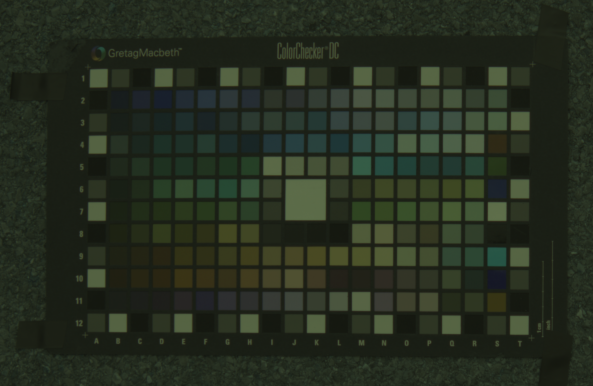


In [15]:
# Download the image
!wget https://www.dropbox.com/s/5qr8rcfcpq4iyhr/img.tiff

# Download the dark frame
!wget https://www.dropbox.com/s/6l87ggjr1hzahw7/dark_frame.tiff


--2024-10-04 13:03:37--  https://www.dropbox.com/s/5qr8rcfcpq4iyhr/img.tiff
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/nxinbbbt2qsjsa3o7ooob/img.tiff?rlkey=5jwkmpkjvnygjp1niv7u2bklj [following]
--2024-10-04 13:03:37--  https://www.dropbox.com/scl/fi/nxinbbbt2qsjsa3o7ooob/img.tiff?rlkey=5jwkmpkjvnygjp1niv7u2bklj
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0f3f4d173a15325356c3178eae.dl.dropboxusercontent.com/cd/0/inline/CbwoJUz83ChKewLN6hDB2wwb-WoijUaRrBHjcw3FTRL9tTryL-xPnZkWf93JnlFs47S_YUjc7XRq2qsaXusvIIdd4lkDTRKiWrqW6WeWorFTJf9cEoSmER8JCcblE90djQZoJvMPiGl9kQVUfojg_XEb/file# [following]
--2024-10-04 13:03:38--  https://uc0f3f4d173a15325356c3178eae.dl.dropboxusercontent.com/cd/0/inline/CbwoJUz83ChKe

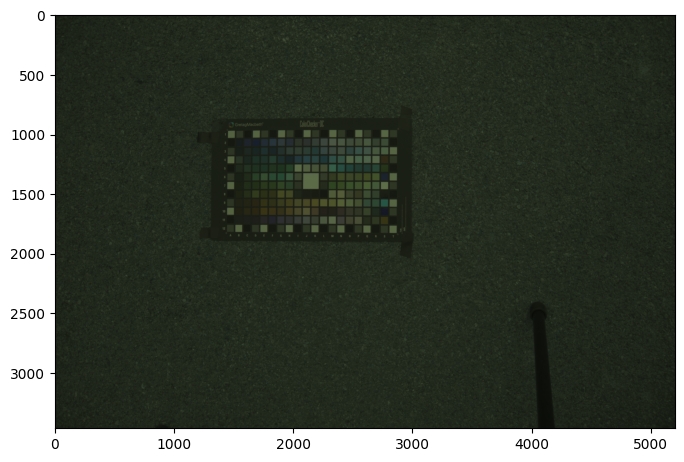

In [19]:
# Let's read the images and do the dark frame subtraction
img2 = cv2.imread("img.tiff", cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
dark_frame2 = cv2.imread("dark_frame.tiff", cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

black_level2 = round(np.mean(dark_frame2))
img2 = cv2.subtract(img2, dark_frame2)

# Select the correct bayer pattern and scale the resulting image in the range [0-1]
# your code goes here
colour_img2 = cv2.cvtColor(img2, cv2.COLOR_BAYER_RG2RGB)
colour_img_display2 = colour_img2.astype(np.float32)/((2**16-1)-black_level2)

#Let's visualise the result
fig=plt.figure(figsize=(8, 8))
plt.imshow(np.power(colour_img_display2,1/2.2))

# Task 2: colour correction

---
Let's return to the camera used in the first example, and this time load the entire image (at half resolution to avoid running out of memory in Colab). For this camera, we have knowledge of its spectral sensitivity.

Using the equations discussed in the lecture slides, calculate the colours as measured by the camera, and as perceived by a human observer. Afterward, perform color correction on the image and display the resulting image in simplified sRGB format. Compare it with the image before color correction.

The spectral data required for this task (ranging from 400nm to 700nm with a 10nm resolution) can be found at the following links:

*   light spectrum (D65): https://www.dropbox.com/s/qqmaq88oa9z7nx5/light_spectrum.txt

*   spectral reflectances: https://www.dropbox.com/s/3er06l5toig4er6/spectral_reflectances.txt
*   CIE colour matching functions: https://www.dropbox.com/s/zh0t3bqwxx8xknc/CIE_1931_CMFs.txt
*   camera spectral sensitivity: https://www.dropbox.com/s/y6q8vkw5gayohkc/camera_spectral_sensitivity.txt

Suggestion: Rescale the simulated camera RGB values so that the maximum is 0.95. Since we haven't accounted for factors like exposure time, this will provide a rough approximation of exposure control.

At each step, be mindful of out-of-gamut values: negative RGB coordinates or values exceeding 1 should be clamped!

Before visualizing the original (debayered) image and the color-corrected one, scale their (linear) values by 4; the image was slightly underexposed.




In [20]:
!wget https://www.dropbox.com/s/3er06l5toig4er6/spectral_reflectances.txt
!wget https://www.dropbox.com/s/zh0t3bqwxx8xknc/CIE_1931_CMFs.txt
!wget https://www.dropbox.com/s/qqmaq88oa9z7nx5/light_spectrum.txt
!wget https://www.dropbox.com/s/y6q8vkw5gayohkc/camera_spectral_sensitivity.txt

# Download the image
!wget https://www.dropbox.com/s/88ayc2xoi56mb32/IMG_FG_small.tiff

# Download the dark frame
!wget https://www.dropbox.com/s/8r8s2uq7nqth2nf/IMG_DF_small.tiff


--2024-10-04 13:12:35--  https://www.dropbox.com/s/3er06l5toig4er6/spectral_reflectances.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/ctsek2s66mw6gvwnak30o/spectral_reflectances.txt?rlkey=j1teptgd38l37r4qv4ghk4lqq [following]
--2024-10-04 13:12:35--  https://www.dropbox.com/scl/fi/ctsek2s66mw6gvwnak30o/spectral_reflectances.txt?rlkey=j1teptgd38l37r4qv4ghk4lqq
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3520680270869d0667f2581153.dl.dropboxusercontent.com/cd/0/inline/CbyNEalXXdUkL3YdY_4qyDMBYOwzVOETF-gi10sCw8x1Irea-wjozbE-TDhg-zIqYR7VVqq46rjrcrhkbQi6CW7xZwIlvm1T20T5fvzYKGz1yV1gzAnBMOgWPITpx_Mw5LvPS0hhDNFtBxSWSynURcU8/file# [following]
--2024-10-04 13:12:35--  https://uc3520680270869d0667f2581153.

In [30]:
light_spectrum = np.loadtxt('light_spectrum.txt');
print(light_spectrum)
reflectances = np.loadtxt('spectral_reflectances.txt');
print(reflectances)

[0.70243184 0.77654229 0.79305843 0.735768   0.89010457 0.99317557
 1.         0.97495162 0.98396598 0.92359861 0.92820765 0.91503412
 0.88946797 0.91407497 0.88620005 0.88315282 0.84880997 0.81769429
 0.81305809 0.75277221 0.7639816  0.76052609 0.74439531 0.70696194
 0.71044715 0.67927546 0.68086952 0.69838217 0.66448409 0.59180134
 0.60782518]
[[0.032891 0.087658 0.163025 0.277209 0.357304 0.412841 0.197129 0.284094
  0.057852 0.049777 0.054038 0.169537 0.063611 0.063919 0.168661 0.131881
  0.252961 0.054112 0.248335 0.323049 0.059351 0.259006 0.168498 0.064895]
 [0.032748 0.091251 0.181166 0.338599 0.51053  0.652585 0.245704 0.355827
  0.058158 0.049915 0.055748 0.215671 0.065353 0.065527 0.188954 0.137386
  0.317085 0.055135 0.300345 0.416933 0.060294 0.318429 0.186052 0.065881]
 [0.03219  0.091676 0.186651 0.358869 0.585951 0.838629 0.271786 0.37447
  0.058447 0.049924 0.057035 0.247972 0.065317 0.06607  0.187376 0.134396
  0.356159 0.055605 0.32457  0.447722 0.061203 0.336131 0.1

In [29]:
img3 = cv2.imread("IMG_FG_small.tiff", cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
dark_frame3 = cv2.imread("IMG_DF_small.tiff", cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

# the black level is the same as in the first example, since it is the same camera at the same exposure
black_level = round(np.mean(dark_frame3))
# the bayer pattern is the same we have seen in the example for the first camera used in this practical
img3 = cv2.subtract(img3, dark_frame3)
colour_img3 = cv2.cvtColor(img3, cv2.COLOR_BAYER_GR2RGB)

# normalise the values in [0-1]
colour_img_before_correction = colour_img3.astype(np.float32)/((2**16-1)-black_level)

#Let's load the spectral data. Since all the spectra has been sampled at 10nm steps in the range 400-700nm, we have 31 bins.
#Therefore, the SPD data is contained in a column vector 31x1, the reflectances are contained in a matrix 31x24 (they refer to a standard colour chart with 24 patches), the CMFs in a matrix 31x3 (same size as the css one)
light_spectrum = np.loadtxt('light_spectrum.txt');
reflectances = np.loadtxt('spectral_reflectances.txt');
cie_cmfs = np.loadtxt('CIE_1931_CMFs.txt');
css = np.loadtxt('camera_spectral_sensitivity.txt');

# Let's compute the white point of the SPD, which is the XYZ values for the given light spectrum.
# In particular, we need the Y component, as it will be used to normalize the XYZ values of the color patches.


#Let's compute the XYZ tristimulus values of the colour chart (the given reflectances refer to the chart)
# It is a straightforward implementation of the equations seen in the lecture slides
cc_XYZ = np.empty((len(reflectances[0]),3))
# your code goes here

# compute the RGB values from the XYZ tristimulus values,
# either using the openCV built-in function
# or we could use the XYZ->RGB matrix

matrix_XYZ2RGB = np.array([[3.240479, -1.53715, -0.498535],
                  [-0.969256, 1.875991, 0.041556],
                  [0.055648, -0.204043, 1.057311]])

cc_RGB = # your code goes here

#some values might be outside the [0-1] range in linear RGB - that is, out of gamut. Let's clamp them!
# your code goes here


#Let's move on to the simulated RGB values in camera space of the colour chart
cc_simulated_RGB = np.empty((len(reflectances[0]),3))
# your code goes here

# let's rescale the simulated RGB values as suggested - the max (which typically corresponds to one of the rgb channels of the white patch) will be set to 0.95
# your code goes here

#the values should all be positive, given that all the terms used must be positive. Sometimes, there might be issues in the data, so just in case let's clamp the RGB values:
# your code goes here

# find the colour correction matrix M0 as the least-squares solution of cc_simulated_RGB*M0 = cc_RGB
# your code goes here

# apply the colour correction to the input image
colour_img_corrected = # your code goes here

# now there might be negative values (have a look at M0). Again, let's deal with out of gamut values.
colour_img_corrected = # your code goes here


# scale the brightness up; the light source will appear saturated, but the rest of the image will be more visible.
# Let's compare the image before - after correction: colours should be more vivid now!
colour_img_corrected = colour_img_corrected*4;
colour_img_before_correction = colour_img_before_correction*4

fig=plt.figure(figsize=(16, 16))
fig.add_subplot(1,2,1)
plt.imshow(np.power(colour_img_before_correction,1/2.2))
fig.add_subplot(1,2,2)
plt.imshow(np.power(colour_img_corrected,1/2.2))
plt.show()

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 31 is different from 24)

###Task 3: white balancing



---


The colour correction has improved the colour appearance. However, the image was taken under slightly different lighting conditions than D65 (a bit *warmer*), which we used for our computations, resulting in a reddish colour cast. White balancing techniques aim to estimate the illuminant and remove the colour cast. This way, neutral patches will appear as they are supposed to: gray.

While we haven't discussed any white balancing techniques yet, we can perform a rough white balancing by scaling the RGB channels so that the average RGB values in the white patch become as follows: `[0.9934*avgG    avgG    0.9548*avgG]`, where `avgG` represents the average green value in the white patch. If you're wondering where these values come from, you can refer to the 6th row in the RGB matrix derived from the XYZ tristimulus values, which correspond to the RGB colour appearance of a white patch under D65.

Please note that applying such a technique directly to the debayered image, without the prior colour correction step, will not yield the same results because it does not account for the differences between CIE CMFs and camera sensitivities.
Give it a try!

In [ ]:
# this is the approximate location of the white patch, our reference.
patch = colour_img_corrected[2150:2250, 1300:1400]

# let's rescale the values as suggested
colour_img_corrected[:,:,0]= # your code goes here
colour_img_corrected[:,:,2]= # your code goes here

# let's do the same with the image pre-colour correction, so we can compare
patch_noCC = colour_img_before_correction[2150:2250, 1300:1400]
colour_img_before_correction[:,:,0]= # your code goes here
colour_img_before_correction[:,:,2]= # your code goes here


# on the left, we will have vivid colours, white balanced (the greys will look neutral). On the right, it might look white balanced, but the colours are still in camera colour space, so off.
fig=plt.figure(figsize=(16, 16))
fig.add_subplot(1,2,1)
plt.imshow(np.power(colour_img_corrected,1/2.2))
fig.add_subplot(1,2,2)
plt.imshow(np.power(colour_img_before_correction,1/2.2))
plt.show()

###Task 4: Photometry

---

Let's say you can comfortably read a book with an illuminance $E_v = 50$ lux. If you have a $I_v = 150$ cd light bulb, at what distance *d* does it need to be from the book?
In the following diagram, the area of the book is indicated with *A*.

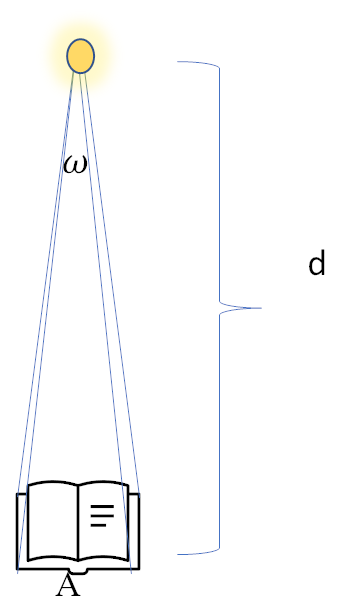

In [26]:
E_v = 50;
I_v = 150;

# You have all that is required to compute d!
d = np.sqrt(I_v/E_v)

print('The distance d is ' + str(d) + ' meters')

The distance d is 1.7320508075688772 meters
